# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/gdrive/My Drive/Amazon reviews data set/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Sorting data according to Time in ascending order
sorted_data=sorted_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
If your trying to do a low carb product.  This works out great.  There are receipies on tova's website on how to make poundcake, pancakes, and a variety of other items.  They turn out pretty great.<br /><br />Try it.  It's a great product.<br /><br /> ~Donna
I had always wanted to try Ghee, but never found it locally.  I ordered it, tried it to fry some fresh haddock, and was amazed at the difference between it and the ordinary frying mediums I had used in the past.<br />It also keeps so well right on the shelf.  Glad I tried it.
I am always looking for good tasting vegan products.  Although I enjoy other Dr. McDougall soups, I didn't care much for the White Bean & Pasta soup. I would not buy it again.


In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
If your trying to do a low carb product.  This works out great.  There are receipies on tova's website on how to make poundcake, pancakes, and a variety of other items.  They turn out pretty great.Try it.  It's a great product. ~Donna
I had always wanted to try Ghee, but never found it locally.  I ordered it, tried it to fry some fresh haddock, and was amazed at the difference between it and the ordinary frying mediums I had used in the past.It also keeps so well right on the shelf.  Glad I tried it.
I am always looking for good tasting vegan products.  Although I enjoy other Dr. McDougall soups, I didn't care much for the White Bean & Pasta soup. I would not buy it again.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I had always wanted to try Ghee, but never found it locally.  I ordered it, tried it to fry some fresh haddock, and was amazed at the difference between it and the ordinary frying mediums I had used in the past.<br />It also keeps so well right on the shelf.  Glad I tried it.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I had always wanted to try Ghee but never found it locally I ordered it tried it to fry some fresh haddock and was amazed at the difference between it and the ordinary frying mediums I had used in the past br It also keeps so well right on the shelf Glad I tried it 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:16<00:00, 2832.28it/s]


In [25]:
preprocessed_reviews[1500]

'always wanted try ghee never found locally ordered tried fry fresh haddock amazed difference ordinary frying mediums used past also keeps well right shelf glad tried'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())


100%|██████████| 46071/46071 [00:10<00:00, 4248.34it/s]


In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(preprocessed_reviews,final['Score'],random_state=100,test_size=0.30,shuffle=False)

X_train2,X_CV,y_train2,y_CV = train_test_split(X_train,y_train,random_state=100,test_size=0.30,shuffle=False)

# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train2)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
features_bow = count_vect.get_feature_names()
final_counts = count_vect.transform(X_train2)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

final_countsCV = count_vect.transform(X_CV)
final_countsTEST = count_vect.transform(X_test)

some feature names  ['aa', 'aaaa', 'aaaaaaaaaaaaaaa', 'aaaaah', 'aaaand', 'aachen', 'aadp', 'aaf', 'aafco', 'aahing']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (22574, 28403)
the number of unique words  28403


## [4.2] Bi-Grams and n-Grams.

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect2 = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vect2.fit(X_train2)
print("some feature names ", count_vect2.get_feature_names()[:10])
print('='*50)

final_bigram_counts = count_vect2.transform(X_train2)

print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

final_bigram_countsCV = count_vect2.transform(X_CV)
final_bigram_countsTEST = count_vect2.transform(X_test)

some feature names  ['ability', 'able', 'able buy', 'able find', 'able get', 'able order', 'absolute', 'absolute favorite', 'absolutely', 'absolutely delicious']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (22574, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train2)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

features_tf_idf = tf_idf_vect.get_feature_names()

final_tf_idf = tf_idf_vect.transform(X_train2)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

final_tf_idfCV = tf_idf_vect.transform(X_CV)
final_tf_idfTEST = tf_idf_vect.transform(X_test)

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able enjoy', 'able find', 'able get', 'able make', 'able order', 'able purchase']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (22574, 13755)
the number of unique words including both unigrams and bigrams  13755


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence_train=[]
for sentence in X_train2:
    list_of_sentence_train.append(sentence.split())

In [32]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model=Word2Vec(list_of_sentence_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9127
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'stuff', 'sugar', 'free', 'not', 'rot', 'gums']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

#  Converting Train data text

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 22574/22574 [00:34<00:00, 649.43it/s]

(22574, 50)
[-0.39121248 -0.03398471  0.12923761  0.23551049  0.593167   -0.26778279
  0.11832981  0.22280185  0.89757863  0.40061415 -0.09806748  0.07641395
 -0.04457859  0.1232284   0.30057781 -0.18844781 -0.24678944  0.2611325
 -0.15052114 -0.18573073  0.30942018  0.1087582  -0.53194922 -0.55779427
 -0.26252983 -0.13629994 -0.1273537  -0.32489223  0.33624029  0.27137535
  0.44534485 -0.23850583 -0.40364443 -0.10640611 -0.11113001 -0.14182399
 -0.040078   -0.5695989  -0.29700596  0.16453971 -0.13248035 -0.20360069
  0.45319513  0.24885814  0.22882987 -0.49286299  0.2846238   0.22641032
 -0.36604242  0.07606014]


# Converting CV data text

In [34]:
i=0
list_of_sentence_cv=[]
for sentence in X_CV:
    list_of_sentence_cv.append(sentence.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 9675/9675 [00:15<00:00, 639.71it/s]

(9675, 50)
[ 0.00969488 -0.00656673  0.31657158  0.13635075  0.33000201 -0.27111033
  0.00729157  0.23201187  0.96946672  0.46185328 -0.12397174  0.34016832
 -0.05776058  0.34936183  0.03097509 -0.50410969 -0.19064083  0.10342966
 -0.31855013 -0.22221942  0.27745742 -0.05937665  0.04532179 -0.35096025
 -0.11701792 -0.09303231  0.1909925  -0.02014343  0.40078878  0.42023277
  0.84680809 -0.55520154 -0.27446657  0.06948459 -0.06254939 -0.14749572
 -0.17382305 -0.30993009 -0.25411601  0.08109908 -0.08965343 -0.14660645
  0.41286019  0.40184436  0.1671248  -0.34086832  0.43856508  0.27473207
 -0.272299   -0.22271673]


#  Converting Test data text

In [35]:
i=0
list_of_sentence_test=[]
for sentence in X_test:
    list_of_sentence_test.append(sentence.split())

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 13822/13822 [00:21<00:00, 652.24it/s]

(13822, 50)
[ 0.437262    0.38539474  0.20016081  0.36017415  0.18672555 -0.52581641
  0.77943567  0.45214069  0.63359075  0.27682842 -0.00791224  0.72071781
 -0.55021515  0.40500519  0.12097677 -0.37679925  0.36240901 -0.14965183
 -0.0947833   0.84307868 -0.05958281  0.14276979  0.01865366 -0.35426856
 -0.97352654  0.12755928 -0.73237455 -0.08085587  0.26112995  0.41776403
  0.72578274 -0.37899226 -0.76315234  0.40362938  0.05807047 -0.90097976
 -0.33581022 -0.99683117  0.3001098   0.05266119  0.26120386 -0.11079777
  0.36861232 -0.01490829  0.88900171 -0.43999946  0.59244729  1.05246886
 -0.39390135 -0.68014367]


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model_tf = TfidfVectorizer()
tf_idf_matrix = model_tf.fit_transform(X_train2)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_tf.get_feature_names(), list(model_tf.idf_)))

#  Calculating TFIDF weighted W2V for training data

In [37]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_tf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 22574/22574 [04:36<00:00, 81.51it/s]


# Calculating TFIDF weighted W2V for CV data

In [38]:

tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1

100%|██████████| 9675/9675 [01:58<00:00, 81.34it/s]


# Calculating TFIDF weighted W2V for CV data

In [39]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 13822/13822 [02:45<00:00, 83.58it/s] 


In [0]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
tfidf_sent_vectors_CV = np.array(tfidf_sent_vectors_CV)
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics

alpha_list = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**2,10**3,10**4]
penalty = ['l1','l2']

AUC_bow_train = []
AUC_bow_CV = []


for a in alpha_list:
    for p in penalty:
        SGD = SGDClassifier(alpha=a,penalty=p,loss='hinge')
        CC = CalibratedClassifierCV(SGD,method='sigmoid',cv=5)
        CC.fit(final_counts,y_train2)
        
        y_pred1 = CC.predict_proba(final_counts)[:,1]
        AUC_bow_train.append([metrics.roc_auc_score(y_train2,y_pred1),a,p])
        
        y_pred2 = CC.predict_proba(final_countsCV)[:,1]
        AUC_bow_CV.append([metrics.roc_auc_score(y_CV,y_pred2),a,p])
        



In [0]:
#AUC_bow_train

In [0]:
#getting the parameters for which AUC score is highest

best_AUC_bow_train= max([i[0] for i in AUC_bow_train])

In [44]:
for i in AUC_bow_train:
    if i[0] == best_AUC_bow_train:
        optimal_alpha_bow = i[1]
        optimal_penalty_bow=i[2]
print('optimal_alpha_bow ',optimal_alpha_bow)
print('optimal_penalty_bow ',optimal_penalty_bow)

optimal_alpha_bow  0.0001
optimal_penalty_bow  l2


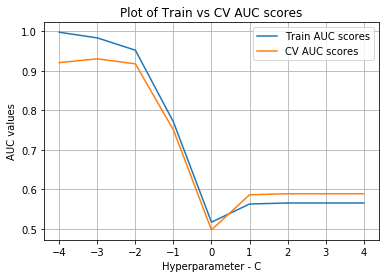

In [45]:
#getting the AUC score from train and CV data and plotting a ROC curve to test the hyperparameters
#we have l2 penalty as the best one ,so calculating AUC scores using l2 to plot roc curve

train_auc_scores = [i[0] for i in AUC_bow_train if i[2]=='l2']
cv_auc_scores = [i[0] for i in AUC_bow_CV if i[2] == 'l2']

plt.plot(np.log10(alpha_list),train_auc_scores,label='Train AUC scores')
plt.plot(np.log10(alpha_list),cv_auc_scores,label='CV AUC scores')
plt.title('Plot of Train vs CV AUC scores')
plt.legend()
plt.grid()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')
plt.show()

Observation : Hyperparameters from Train data is performing well on CV data too,so moving forward with the same results

Text(0.5, 1.0, 'ROC curve of train and test data')

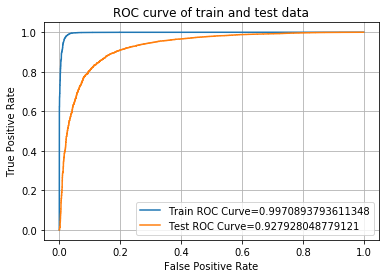

In [46]:
SGD = SGDClassifier(alpha=optimal_alpha_bow,penalty=optimal_penalty_bow)
calibration = CalibratedClassifierCV(SGD,method='sigmoid',cv=5)

calibration.fit(final_counts,y_train2)
pred_prob_train = calibration.predict_proba(final_counts)[:,1]
fpr_train,tpr_train,t1 = roc_curve(y_train2,pred_prob_train)

pred_prob_test = calibration.predict_proba(final_countsTEST)[:,1]
fpr_test,tpr_test,t2 = roc_curve(y_test,pred_prob_test)

plt.plot(fpr_train,tpr_train,label='Train ROC Curve=' +str(metrics.auc(fpr_train,tpr_train)))
plt.plot(fpr_test,tpr_test,label='Test ROC Curve=' +str(metrics.auc(fpr_test,tpr_test)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')

In [0]:
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import binarize

def find_best_threshold(thresh, fpr, tpr):
    t = thresh[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, thresh):
    predictions = []
    for i in proba:
        if i>=thresh:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.9597840254806888 for threshold 0.729
*********Train confusion matrix*********
[[ 3230   107]
 [  162 19075]]


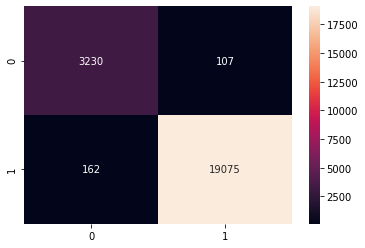

In [48]:
best_t = find_best_threshold(t1,fpr_train,tpr_train)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(pred_prob_train, best_t)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(pred_prob_train, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[ 1887   641]
 [  764 10530]]


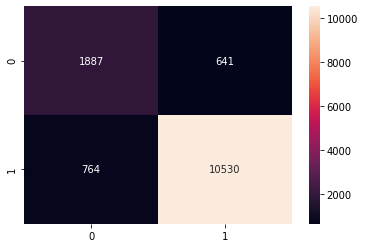

In [49]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(pred_prob_test, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(pred_prob_test, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

# Top 10 positive features for BOW vectorizer

In [50]:
SGD = SGDClassifier(alpha=optimal_alpha_bow,penalty=optimal_penalty_bow)
SGD.fit(final_counts,y_train2)
w_pos = np.argsort(SGD.coef_)[:,::-1]

for i in w_pos[0][:10]:
    print(features_bow[i])



pleased
skeptical
delicious
coat
awesome
perfect
pleasantly
breath
bright
amazing


# Top 10 negative features for BOW vectorizer

In [51]:
w_neg = np.argsort(SGD.coef_)

for i in w_neg[0][:10]:
    print(features_bow[i])

worst
disappointing
terrible
died
awful
chewed
terribly
disgusting
trash
hopes


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
alpha_list = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**2,10**3,10**4]
penalty = ['l1','l2']

AUC_tfidf_train = []
AUC_tfidf_CV = []


for a in alpha_list:
    for p in penalty:
        SGD = SGDClassifier(alpha=a,penalty=p,loss='hinge')
        CC = CalibratedClassifierCV(SGD,method='sigmoid',cv=5)
        CC.fit(final_tf_idf,y_train2)
        
        y_pred1 = CC.predict_proba(final_tf_idf)[:,1]
        AUC_tfidf_train.append([metrics.roc_auc_score(y_train2,y_pred1),a,p])
        
        y_pred2 = CC.predict_proba(final_tf_idfCV)[:,1]
        AUC_tfidf_CV.append([metrics.roc_auc_score(y_CV,y_pred2),a,p])
        

In [53]:
#getting the parameters for which AUC score is highest

best_AUC_tfidf_train= max([i[0] for i in AUC_tfidf_train])

for i in AUC_tfidf_train:
    if i[0] == best_AUC_tfidf_train:
        optimal_alpha_tfidf = i[1]
        optimal_penalty_tfidf=i[2]
print('optimal_alpha_tfidf ',optimal_alpha_tfidf)
print('optimal_penalty_tfidf ',optimal_penalty_tfidf)

optimal_alpha_tfidf  0.0001
optimal_penalty_tfidf  l2


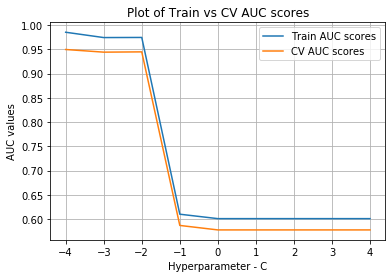

In [54]:
#getting the AUC score from train and CV data and plotting a ROC curve to test the hyperparameters
#we have l2 penalty as the best one ,so calculating AUC scores using l2 to plot roc curve

train_auc_scores = [i[0] for i in AUC_tfidf_train if i[2]=='l2']
cv_auc_scores = [i[0] for i in AUC_tfidf_CV if i[2] == 'l2']

plt.plot(np.log10(alpha_list),train_auc_scores,label='Train AUC scores')
plt.plot(np.log10(alpha_list),cv_auc_scores,label='CV AUC scores')
plt.title('Plot of Train vs CV AUC scores')
plt.grid()
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')
plt.show()

#Observation : Hyperparameters from Train data is performing well on CV data too,so moving forward with the same results


Text(0.5, 1.0, 'ROC curve of train and test data')

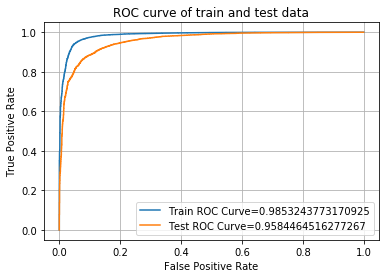

In [55]:
#Since we are done with our hyperparameter tuning scene,now showing results on test data through ROC curve
#Plotting ROC curve as FPR vs TPR

SGD = SGDClassifier(alpha=optimal_alpha_tfidf,penalty=optimal_penalty_tfidf)
calibration = CalibratedClassifierCV(SGD,method='sigmoid',cv=5)

calibration.fit(final_tf_idf,y_train2)
pred_prob_train = calibration.predict_proba(final_tf_idf)[:,1]
fpr_train,tpr_train,t1 = roc_curve(y_train2,pred_prob_train)

pred_prob_test = calibration.predict_proba(final_tf_idfTEST)[:,1]
fpr_test,tpr_test,t2 = roc_curve(y_test,pred_prob_test)

plt.plot(fpr_train,tpr_train,label='Train ROC Curve=' +str(metrics.auc(fpr_train,tpr_train)))
plt.plot(fpr_test,tpr_test,label='Test ROC Curve=' +str(metrics.auc(fpr_test,tpr_test)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')


the maximum value of tpr*(1-fpr) 0.895666484909953 for threshold 0.839
*********Train confusion matrix*********
[[ 3151   186]
 [  990 18247]]


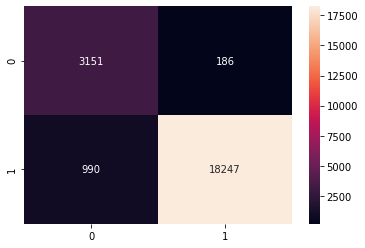

In [56]:
best_t = find_best_threshold(t1,fpr_train,tpr_train)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(pred_prob_train, best_t)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(pred_prob_train, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[ 2242   286]
 [ 1195 10099]]


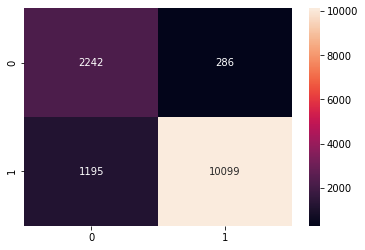

In [57]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(pred_prob_test, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(pred_prob_test, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

# Top features for TFIDF vectorizer

In [58]:
# Top 10 positive features for tfidf vectorizer

print('----------------Top 10 positive features for tfidf vectorizer-----------------\n')

SGD = SGDClassifier(alpha=optimal_alpha_tfidf,penalty=optimal_penalty_tfidf)
SGD.fit(final_tf_idf,y_train2)
w_pos = np.argsort(SGD.coef_)[:,::-1]

for i in w_pos[0][:10]:
    print(features_tf_idf[i])



print('----------------Top 10 negative features for tfidf vectorizer------------------\n')

w_neg = np.argsort(SGD.coef_)

for i in w_neg[0][:10]:
    print(features_tf_idf[i])

----------------Top 10 positive features for tfidf vectorizer-----------------

great
best
good
delicious
not disappointed
perfect
love
loves
excellent
wonderful
----------------Top 10 negative features for tfidf vectorizer------------------

worst
disappointed
not worth
horrible
terrible
awful
return
threw
not
not buy


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
alpha_list = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**2,10**3,10**4]
penalty = ['l1','l2']

AUC_avgw2v_train = []
AUC_avgw2v_CV = []


for a in alpha_list:
    for p in penalty:
        SGD = SGDClassifier(alpha=a,penalty=p,loss='hinge')
        CC = CalibratedClassifierCV(SGD,method='sigmoid',cv=5)
        CC.fit(sent_vectors_train,y_train2)
        
        y_pred1 = CC.predict_proba(sent_vectors_train)[:,1]
        AUC_avgw2v_train.append([metrics.roc_auc_score(y_train2,y_pred1),a,p])
        
        y_pred2 = CC.predict_proba(sent_vectors_cv)[:,1]
        AUC_avgw2v_CV.append([metrics.roc_auc_score(y_CV,y_pred2),a,p])
        

In [60]:
#getting the parameters for which AUC score is highest

best_AUC_avgw2v_train= max([i[0] for i in AUC_avgw2v_train])

for i in AUC_avgw2v_train:
    if i[0] == best_AUC_avgw2v_train:
        optimal_alpha_avgw2v = i[1]
        optimal_penalty_avgw2v=i[2]
print('optimal_alpha_avgw2v ',optimal_alpha_avgw2v)
print('optimal_penalty_avgw2v ',optimal_penalty_avgw2v)


optimal_alpha_avgw2v  0.0001
optimal_penalty_avgw2v  l2


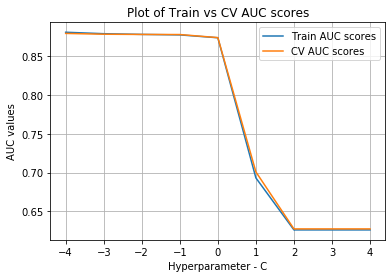

In [61]:
#getting the AUC score from train and CV data and plotting a ROC curve to test the hyperparameters
#we have l2 penalty as the best one ,so calculating AUC scores using optimal_penalty_avgw2v to plot roc curve

train_auc_scores = [i[0] for i in AUC_avgw2v_train if i[2]==optimal_penalty_avgw2v]
cv_auc_scores = [i[0] for i in AUC_avgw2v_CV if i[2] == optimal_penalty_avgw2v]

plt.plot(np.log10(alpha_list),train_auc_scores,label='Train AUC scores')
plt.plot(np.log10(alpha_list),cv_auc_scores,label='CV AUC scores')
plt.title('Plot of Train vs CV AUC scores')
plt.legend()
plt.grid()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')
plt.show()

#Observation : Hyperparameters from Train data is performing well on CV data too,so moving forward with the same results


Text(0.5, 1.0, 'ROC curve of train and test data')

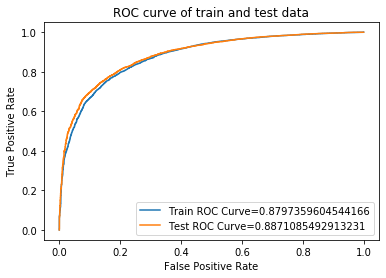

In [62]:
#Since we are done with our hyperparameter tuning scene,now showing results on test data through ROC curve
#Plotting ROC curve as FPR vs TPR

SGD = SGDClassifier(alpha=optimal_alpha_avgw2v,penalty=optimal_penalty_avgw2v)
calibration = CalibratedClassifierCV(SGD,method='sigmoid',cv=5)

calibration.fit(sent_vectors_train,y_train2)
pred_prob_train = calibration.predict_proba(sent_vectors_train)[:,1]
fpr_train,tpr_train,t1 = roc_curve(y_train2,pred_prob_train)

pred_prob_test = calibration.predict_proba(sent_vectors_test)[:,1]
fpr_test,tpr_test,t2 = roc_curve(y_test,pred_prob_test)


plt.plot(fpr_train,tpr_train,label='Train ROC Curve=' +str(metrics.auc(fpr_train,tpr_train)))
plt.plot(fpr_test,tpr_test,label='Test ROC Curve=' +str(metrics.auc(fpr_test,tpr_test)))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')

the maximum value of tpr*(1-fpr) 0.6387723413274872 for threshold 0.85
*********Train confusion matrix*********
[[ 2774   563]
 [ 4455 14782]]


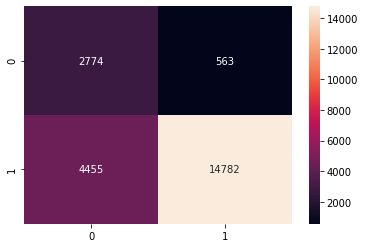

In [63]:
#Finding the threshold value of probability on train data and then showng results on test data
best_t = find_best_threshold(t1,fpr_train,tpr_train)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(pred_prob_train, best_t)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(pred_prob_train, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[2102  426]
 [2489 8805]]


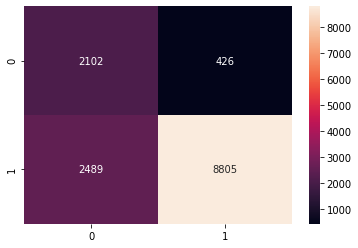

In [64]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(pred_prob_test, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(pred_prob_test, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
alpha_list = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**2,10**3,10**4]
penalty = ['l1','l2']

AUC_tfw2v_train = []
AUC_tfw2v_CV = []


for a in alpha_list:
    for p in penalty:
        SGD = SGDClassifier(alpha=a,penalty=p,loss='hinge')
        CC = CalibratedClassifierCV(SGD,method='sigmoid',cv=5)
        CC.fit(tfidf_sent_vectors_train,y_train2)
        
        y_pred1 = CC.predict_proba(tfidf_sent_vectors_train)[:,1]
        AUC_tfw2v_train.append([metrics.roc_auc_score(y_train2,y_pred1),a,p])
        
        y_pred2 = CC.predict_proba(tfidf_sent_vectors_CV)[:,1]
        AUC_tfw2v_CV.append([metrics.roc_auc_score(y_CV,y_pred2),a,p])
        

In [66]:
#getting the parameters for which AUC score is highest

best_AUC_tfw2v_train= max([i[0] for i in AUC_tfw2v_train])

for i in AUC_tfw2v_train:
    if i[0] == best_AUC_tfw2v_train:
        optimal_alpha_tfw2v = i[1]
        optimal_penalty_tfw2v=i[2]
print('optimal_alpha_tfw2v ',optimal_alpha_tfw2v)
print('optimal_penalty_tfw2v ',optimal_penalty_tfw2v)


optimal_alpha_tfw2v  0.01
optimal_penalty_tfw2v  l2


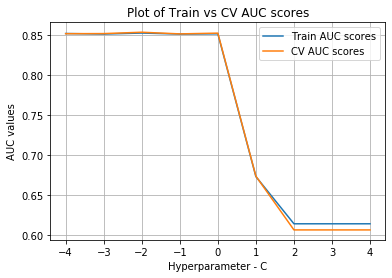

In [67]:
#getting the AUC score from train and CV data and plotting a ROC curve to test the hyperparameters
#we have l2 penalty as the best one ,so calculating AUC scores using optimal_penalty_tfw2v to plot roc curve

train_auc_scores = [i[0] for i in AUC_tfw2v_train if i[2]==optimal_penalty_tfw2v]
cv_auc_scores = [i[0] for i in AUC_tfw2v_CV if i[2] == optimal_penalty_tfw2v]

plt.plot(np.log10(alpha_list),train_auc_scores,label='Train AUC scores')
plt.plot(np.log10(alpha_list),cv_auc_scores,label='CV AUC scores')
plt.title('Plot of Train vs CV AUC scores')
plt.legend()
plt.grid()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')
plt.show()

#Observation : Hyperparameters from Train data is performing well on CV data too,so moving forward with the same results


Text(0.5, 1.0, 'ROC curve of train and test data')

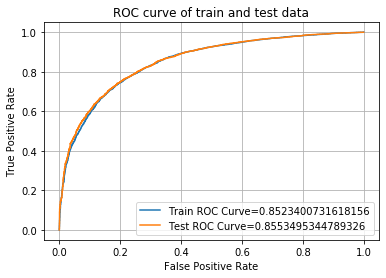

In [68]:
#Since we are done with our hyperparameter tuning scene,now showing results on test data through ROC curve
#Plotting ROC curve as FPR vs TPR

SGD = SGDClassifier(alpha=optimal_alpha_tfw2v,penalty=optimal_penalty_tfw2v)
calibration = CalibratedClassifierCV(SGD,method='sigmoid',cv=5)

calibration.fit(tfidf_sent_vectors_train,y_train2)
pred_prob_train = calibration.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr_train,tpr_train,t1 = roc_curve(y_train2,pred_prob_train)

pred_prob_test = calibration.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr_test,tpr_test,t2 = roc_curve(y_test,pred_prob_test)


plt.plot(fpr_train,tpr_train,label='Train ROC Curve=' +str(metrics.auc(fpr_train,tpr_train)))
plt.plot(fpr_test,tpr_test,label='Test ROC Curve=' +str(metrics.auc(fpr_test,tpr_test)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')


the maximum value of tpr*(1-fpr) 0.5979833993180875 for threshold 0.846
*********Train confusion matrix*********
[[ 2626   711]
 [ 4619 14618]]


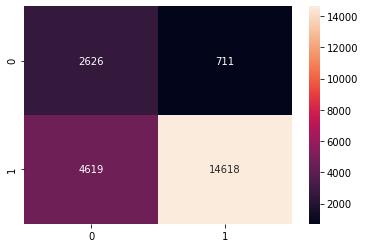

In [69]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr_train,tpr_train)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train2, predict_with_best_t(pred_prob_train, best_t)))
cm_tr = confusion_matrix(y_train2, predict_with_best_t(pred_prob_train, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[1994  534]
 [2701 8593]]


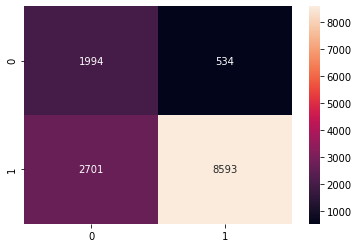

In [70]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test, predict_with_best_t(pred_prob_test, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(pred_prob_test, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

## [5.2] RBF SVM

In [71]:
#taking sampled features for RBF kernel and max_features=500,min_df=10
from sklearn.model_selection import train_test_split

X_train_rbf,X_test_rbf,y_train_rbf,y_test_rbf = train_test_split(preprocessed_reviews[:18000],final['Score'][:18000],random_state=100,test_size=0.30,shuffle=False)

#X_train_rbf,X_CV_rbf,y_train_rbf,y_CV_rbf = train_test_split(X_train,y_train,random_state=100,test_size=0.30,shuffle=False)

# [4] Featurization

## [4.1] BAG OF WORDS

#BoW
count_vect_rbf = CountVectorizer(min_df=10,max_features=500) #in scikit-learn
count_vect_rbf.fit(X_train_rbf)
print("some feature names ", count_vect_rbf.get_feature_names()[:10])
print('='*50)
features_bow_rbf = count_vect_rbf.get_feature_names()
final_counts_rbf = count_vect_rbf.transform(X_train_rbf)
print("the type of count vectorizer ",type(final_counts_rbf))
print("the shape of out text BOW vectorizer ",final_counts_rbf.get_shape())
print("the number of unique words ", final_counts_rbf.get_shape()[1])

#final_countsCV_rbf = count_vect_rbf.transform(X_CV_rbf)
final_countsTEST_rbf = count_vect_rbf.transform(X_test_rbf)

## [4.2] Bi-Grams and n-Grams.

#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect2_rbf = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
count_vect2_rbf.fit(X_train_rbf)
print("some feature names ", count_vect2_rbf.get_feature_names()[:10])
print('='*50)

final_bigram_counts_rbf = count_vect2_rbf.transform(X_train_rbf)

print("the type of count vectorizer ",type(final_bigram_counts_rbf))
print("the shape of out text BOW vectorizer ",final_bigram_counts_rbf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_rbf.get_shape()[1])

#final_bigram_countsCV_rbf = count_vect2_rbf.transform(X_CV_rbf)
final_bigram_countsTEST_rbf = count_vect2_rbf.transform(X_test_rbf)

## [4.3] TF-IDF

tf_idf_vect_rbf = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
tf_idf_vect_rbf.fit(X_train_rbf)
print("some sample features(unique words in the corpus)",tf_idf_vect_rbf.get_feature_names()[0:10])
print('='*50)

features_tf_idf_rbf = tf_idf_vect_rbf.get_feature_names()

final_tf_idf_rbf = tf_idf_vect_rbf.transform(X_train_rbf)
print("the type of count vectorizer ",type(final_tf_idf_rbf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_rbf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_rbf.get_shape()[1])

#final_tf_idfCV_rbf = tf_idf_vect_rbf.transform(X_CV_rbf)
final_tf_idfTEST_rbf = tf_idf_vect_rbf.transform(X_test_rbf)

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (12600, 500)
the number of unique words  500
some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almonds', 'almost', 'also', 'alternative']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (12600, 500)
the number of unique words including both unigrams and bigrams  500
some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almonds', 'almost', 'also', 'alternative']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (12600, 500)
the number of unique words including both unigrams and bigrams  500


### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [72]:
# Please write all the code with proper documentation
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV

tuned_parameters = {'kernel':['rbf'],'C':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**2,10**3,10**4]}

svc = svm.SVC()

clf = RandomizedSearchCV(svc,tuned_parameters,cv=5,scoring='roc_auc',return_train_score=True)

clf.fit(final_counts_rbf,y_train_rbf)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 100, 1000, 10000],
                                        'kernel': ['rbf']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='roc_auc', verbose=0)

In [73]:
AUC_bow_train_rbf = clf.cv_results_['mean_train_score']
best_auc_score_bow_rbf = clf.best_score_
optimal_C_bow_rbf = clf.best_params_['C']

print('best_auc_score_bow_rbf ',best_auc_score_bow_rbf)
print('optimal_C_bow_rbf ',optimal_C_bow_rbf)

best_auc_score_bow_rbf  0.874320326218017
optimal_C_bow_rbf  1


In [0]:
#finding auc scores for our CV data for validation
AUC_bow_CV_rbf = clf.cv_results_['mean_test_score']


Text(0, 0.5, 'AUC values')

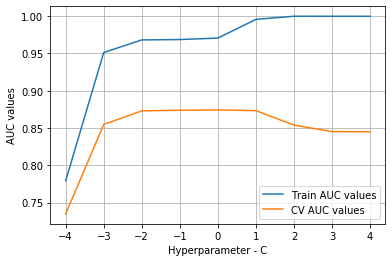

In [75]:
#plotting ROC curve for train and CV data
plt.plot(np.log10(tuned_parameters['C']),AUC_bow_train_rbf,label='Train AUC values')
plt.plot(np.log10(tuned_parameters['C']),AUC_bow_CV_rbf,label='CV AUC values')
plt.legend()
plt.grid()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

#Observation : Our model is performing well when tested with CV data,so we can go ahead with considering best value of C as optimal_C_bow_rbf    

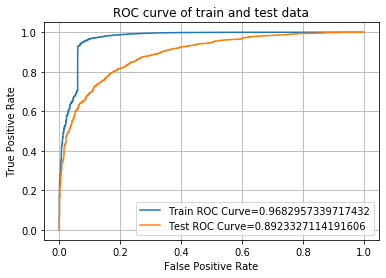

In [76]:
#Since we are done with our hyperparameter tuning scene,now showing results on test data through ROC curve
#Plotting ROC curve as FPR vs TPR

model_roc_rbf = svm.SVC(kernel='rbf',C=optimal_C_bow_rbf,probability=True)
model_roc_rbf = model_roc_rbf.fit(final_counts_rbf,y_train_rbf)

y_pred_train_bow_rbf = model_roc_rbf.predict_proba(final_counts_rbf)[:,1]
fpr_train,tpr_train,t1 = metrics.roc_curve(y_train_rbf,y_pred_train_bow_rbf)

y_pred_test_bow_rbf = model_roc_rbf.predict_proba(final_countsTEST_rbf)[:,1]
fpr_test,tpr_test,t2 = metrics.roc_curve(y_test_rbf,y_pred_test_bow_rbf)

plt.plot(fpr_train,tpr_train,label='Train ROC Curve=' +str(metrics.auc(fpr_train,tpr_train)))
plt.plot(fpr_test,tpr_test,label='Test ROC Curve=' +str(metrics.auc(fpr_test,tpr_test)))
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.8771804824933379 for threshold 0.882
*********Train confusion matrix*********
[[ 1522   120]
 [  588 10370]]


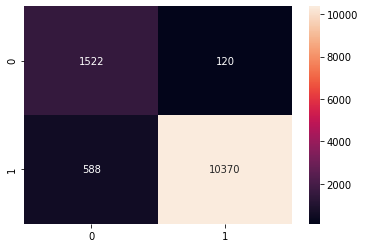

In [77]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr_train,tpr_train)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train_rbf, predict_with_best_t(y_pred_train_bow_rbf, best_t)))
cm_tr = confusion_matrix(y_train_rbf, predict_with_best_t(y_pred_train_bow_rbf, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')


*********Test confusion matrix*********
[[ 821  132]
 [1106 3341]]


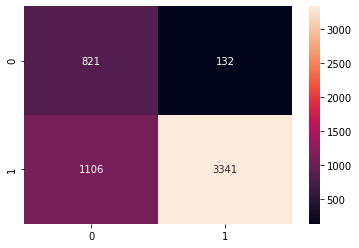

In [78]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test_rbf, predict_with_best_t(y_pred_test_bow_rbf, best_t)))
cm_test = confusion_matrix(y_test_rbf, predict_with_best_t(y_pred_test_bow_rbf, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

best_auc_score_tfidf_rbf  0.8931233088248891
optimal_C_tfidf_rbf  10


Text(0, 0.5, 'AUC values')

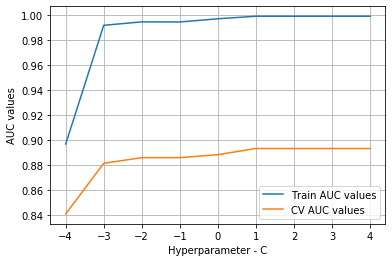

In [79]:
tuned_parameters = {'kernel':['rbf'],'C':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**2,10**3,10**4]}



svc = svm.SVC()

clf = RandomizedSearchCV(svc,tuned_parameters,cv=5,scoring='roc_auc',return_train_score=True)

clf.fit(final_tf_idf_rbf,y_train_rbf)

AUC_tfidf_train_rbf = clf.cv_results_['mean_train_score']
best_auc_score_tfidf_rbf = clf.best_score_
optimal_C_tfidf_rbf = clf.best_params_['C']

print('best_auc_score_tfidf_rbf ',best_auc_score_tfidf_rbf)
print('optimal_C_tfidf_rbf ',optimal_C_tfidf_rbf)

#finding auc scores for our CV data for validation
AUC_tfidf_CV_rbf = clf.cv_results_['mean_test_score']

#plotting ROC curve for train and CV data
plt.plot(np.log10(tuned_parameters['C']),AUC_tfidf_train_rbf,label='Train AUC values')
plt.plot(np.log10(tuned_parameters['C']),AUC_tfidf_CV_rbf,label='CV AUC values')
plt.legend()
plt.grid()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

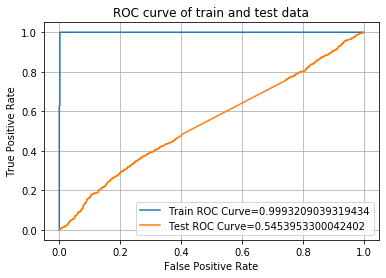

In [80]:
#Since we are done with our hyperparameter tuning scene,now showing results on test data through ROC curve
#Plotting ROC curve as FPR vs TPR

model_roc_rbf = svm.SVC(kernel='rbf',C=optimal_C_tfidf_rbf,probability=True)
model_roc_rbf = model_roc_rbf.fit(final_tf_idf_rbf,y_train_rbf)

y_pred_train_tfidf_rbf = model_roc_rbf.predict_proba(final_tf_idf_rbf)[:,1]
fpr,tpr,t1 = metrics.roc_curve(y_train_rbf,y_pred_train_tfidf_rbf)

y_pred_test_tfidf_rbf = model_roc_rbf.predict_proba(final_countsTEST_rbf)[:,1]
fpr2,tpr2,t2 = metrics.roc_curve(y_test_rbf,y_pred_test_tfidf_rbf)

plt.plot(fpr,tpr,label='Train ROC Curve=' +str(metrics.auc(fpr,tpr)))
plt.plot(fpr2,tpr2,label='Test ROC Curve=' +str(metrics.auc(fpr2,tpr2)))
plt.grid()
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

# Confusion matrix with optimal threshold value of probability

the maximum value of tpr*(1-fpr) 0.9981729598051157 for threshold 0.956
*********Train confusion matrix*********
[[ 1639     3]
 [    0 10958]]


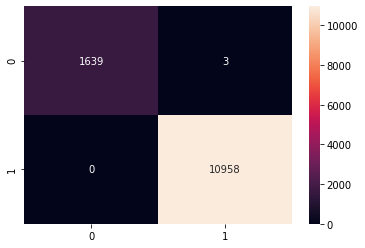

In [81]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr,tpr)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train_rbf, predict_with_best_t(y_pred_train_tfidf_rbf, best_t)))
cm_tr = confusion_matrix(y_train_rbf, predict_with_best_t(y_pred_train_tfidf_rbf, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[ 953    0]
 [4439    8]]


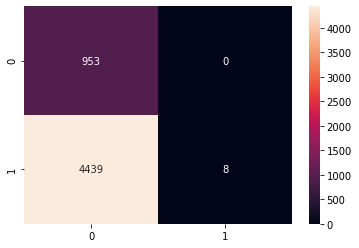

In [82]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test_rbf, predict_with_best_t(y_pred_test_tfidf_rbf, best_t)))
cm_test = confusion_matrix(y_test_rbf, predict_with_best_t(y_pred_test_tfidf_rbf, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [102]:
#taking a subsample from sent_vectors_train as running the whole data might overload the box
print(sent_vectors_train.shape)
sent_vectors_train_rbf = sent_vectors_train[:10000]
y_train_avgw2v_rbf = y_train[:10000]
# sent_vectors_cv_rbf = sent_vectors_train[10000:13000]
# y_cv_avgw2v_rbf = sent_vectors_train[10000:13000]
sent_vectors_test_rbf = sent_vectors_train[10000:13000]
y_test_avgw2v_rbf  = y_test[10000:13000]


(22574, 50)


In [103]:
len(y_test[10000:13000])

3000

best_auc_score_avgw2v_rbf  0.8547524682571719
optimal_C_avgw2v_rbf  10


Text(0, 0.5, 'AUC values')

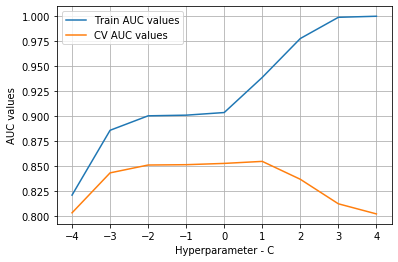

In [104]:
tuned_parameters = {'kernel':['rbf'],'C':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**2,10**3,10**4]}

svc = svm.SVC()

clf = RandomizedSearchCV(svc,tuned_parameters,cv=5,scoring='roc_auc',return_train_score=True)

clf.fit(sent_vectors_train_rbf,y_train_avgw2v_rbf)

AUC_avgw2v_train_rbf = clf.cv_results_['mean_train_score']
best_auc_score_avgw2v_rbf = clf.best_score_
optimal_C_avgw2v_rbf = clf.best_params_['C']

print('best_auc_score_avgw2v_rbf ',best_auc_score_avgw2v_rbf)
print('optimal_C_avgw2v_rbf ',optimal_C_avgw2v_rbf)

#finding auc scores for our CV data for validation
AUC_avgw2v_CV_rbf = clf.cv_results_['mean_test_score']

#plotting ROC curve for train and CV data
plt.plot(np.log10(tuned_parameters['C']),AUC_avgw2v_train_rbf,label='Train AUC values')
plt.plot(np.log10(tuned_parameters['C']),AUC_avgw2v_CV_rbf,label='CV AUC values')
plt.grid()
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

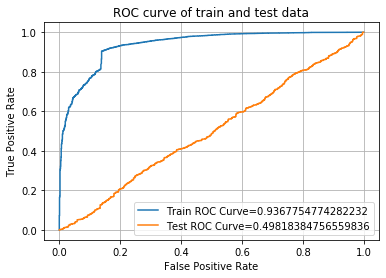

In [105]:
#Since we are done with our hyperparameter tuning scene,now showing results on test data through ROC curve
#Plotting ROC curve as FPR vs TPR

model_roc_rbf = svm.SVC(kernel='rbf',C=optimal_C_avgw2v_rbf,probability=True)
model_roc_rbf = model_roc_rbf.fit(sent_vectors_train_rbf,y_train_avgw2v_rbf)

y_pred_train_avgw2v_rbf = model_roc_rbf.predict_proba(sent_vectors_train_rbf)[:,1]
fpr,tpr,t1 = metrics.roc_curve(y_train_avgw2v_rbf,y_pred_train_avgw2v_rbf)

y_pred_test_avgw2v_rbf = model_roc_rbf.predict_proba(sent_vectors_test_rbf)[:,1]
fpr2,tpr2,t2 = metrics.roc_curve(y_test_avgw2v_rbf,y_pred_test_avgw2v_rbf)

plt.plot(fpr,tpr,label='Train ROC Curve=' +str(metrics.auc(fpr,tpr)))
plt.plot(fpr2,tpr2,label='Test ROC Curve=' +str(metrics.auc(fpr2,tpr2)))
plt.grid()
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

In [109]:
len(y_train_rbf)

12600

the maximum value of tpr*(1-fpr) 0.7788777701476516 for threshold 0.862
*********Train confusion matrix*********
[[1096  177]
 [ 832 7895]]


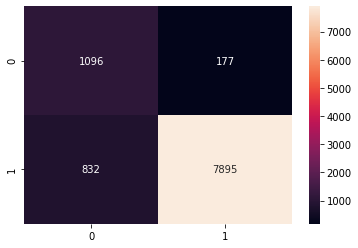

In [110]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr,tpr)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train_avgw2v_rbf, predict_with_best_t(y_pred_train_avgw2v_rbf, best_t)))
cm_tr = confusion_matrix(y_train_avgw2v_rbf, predict_with_best_t(y_pred_train_avgw2v_rbf, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[ 146  383]
 [ 689 1782]]


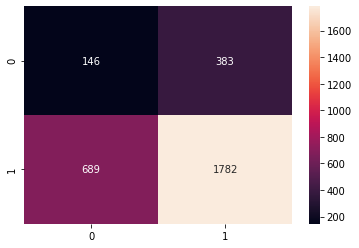

In [112]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test_avgw2v_rbf, predict_with_best_t(y_pred_test_avgw2v_rbf, best_t)))
cm_test = confusion_matrix(y_test_avgw2v_rbf, predict_with_best_t(y_pred_test_avgw2v_rbf, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [113]:
# Please write all the code with proper documentation

#taking a subsample from tfidf_sent_vectors_train as running the whole data might overload the box
print(tfidf_sent_vectors_train.shape)
tfidf_sent_vectors_train_rbf = tfidf_sent_vectors_train[:10000]
y_train_rbf2 = y_train[:10000]
# tfidf_sent_vectors_cv_rbf = tfidf_sent_vectors_train[10000:13000]
# y_cv_rbf2 = sent_vectors_train[10000:13000]
tfidf_sent_vectors_test_rbf = tfidf_sent_vectors_train[10000:13000]
y_test_rbf2  = y_test[10000:13000]

(22574, 50)


In [114]:
len(y_test_rbf2)

3000

best_auc_score_tfw2v_rbf  0.8242475905375052
optimal_C_tfw2v_rbf  10


Text(0, 0.5, 'AUC values')

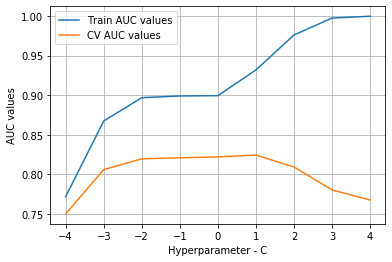

In [115]:
tuned_parameters = {'kernel':['rbf'],'C':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**2,10**3,10**4]}

svc = svm.SVC()

clf = RandomizedSearchCV(svc,tuned_parameters,cv=5,scoring='roc_auc',return_train_score=True)

clf.fit(tfidf_sent_vectors_train_rbf,y_train_rbf2)

AUC_tfw2v_train_rbf = clf.cv_results_['mean_train_score']
best_auc_score_tfw2v_rbf = clf.best_score_
optimal_C_tfw2v_rbf = clf.best_params_['C']

print('best_auc_score_tfw2v_rbf ',best_auc_score_tfw2v_rbf)
print('optimal_C_tfw2v_rbf ',optimal_C_tfw2v_rbf)

#finding auc scores for our CV data for validation
AUC_tfw2v_CV_rbf = clf.cv_results_['mean_test_score']

#plotting ROC curve for train and CV data
plt.plot(np.log10(tuned_parameters['C']),AUC_tfw2v_train_rbf,label='Train AUC values')
plt.plot(np.log10(tuned_parameters['C']),AUC_tfw2v_CV_rbf,label='CV AUC values')
plt.grid()
plt.legend()
plt.xlabel('Hyperparameter - C')
plt.ylabel('AUC values')

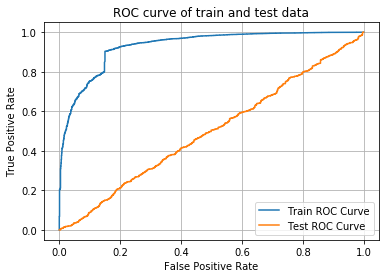

In [116]:
#Since we are done with our hyperparameter tuning scene,now showing results on test data through ROC curve
#Plotting ROC curve as FPR vs TPR

model_roc_rbf = svm.SVC(kernel='rbf',C=optimal_C_tfw2v_rbf,probability=True)
model_roc_rbf = model_roc_rbf.fit(tfidf_sent_vectors_train_rbf,y_train_rbf2)

y_pred_train_tfw2v_rbf = model_roc_rbf.predict_proba(tfidf_sent_vectors_train_rbf)[:,1]
fpr,tpr,t1 = metrics.roc_curve(y_train_rbf2,y_pred_train_tfw2v_rbf)

y_pred_test_tfw2v_rbf = model_roc_rbf.predict_proba(tfidf_sent_vectors_test_rbf)[:,1]
fpr2,tpr2,t2 = metrics.roc_curve(y_test_rbf2,y_pred_test_tfw2v_rbf)

plt.plot(fpr,tpr,label='Train ROC Curve')
plt.plot(fpr2,tpr2,label='Test ROC Curve')
plt.legend()
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of train and test data')
plt.show()

the maximum value of tpr*(1-fpr) 0.767857263410652 for threshold 0.862
*********Train confusion matrix*********
[[1082  191]
 [ 843 7884]]


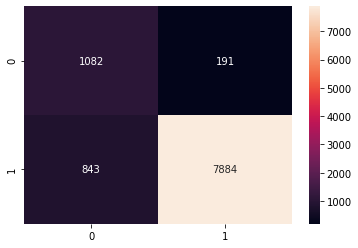

In [117]:
#Finding the threshold value of probability on train data and then showng results on test data

best_t = find_best_threshold(t1,fpr,tpr)
print("*********Train confusion matrix*********")
print(confusion_matrix(y_train_rbf2, predict_with_best_t(y_pred_train_tfw2v_rbf, best_t)))
cm_tr = confusion_matrix(y_train_rbf2, predict_with_best_t(y_pred_train_tfw2v_rbf, best_t))
plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_tr,annot=True,ax=ax2,fmt='g')

*********Test confusion matrix*********
[[ 150  379]
 [ 728 1743]]


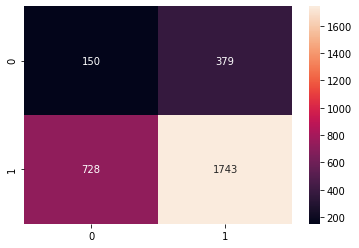

In [118]:
print("*********Test confusion matrix*********")
print(confusion_matrix(y_test_rbf2, predict_with_best_t(y_pred_test_tfw2v_rbf, best_t)))
cm_test = confusion_matrix(y_test_rbf2, predict_with_best_t(y_pred_test_tfw2v_rbf, best_t))

plt.figure()
ax2 = plt.subplot()
sns.heatmap(cm_test,annot=True,ax=ax2,fmt='g')

# [6] Conclusions

In [122]:
# Please compare all your models using Prettytable library
print('Number of data points used for linear SVM : 50k\n')
print('Number of data points used for RBF SVM : 18\n')

from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ['Vectorizer','Kernel','Hyperameter C', 'AUC','Penalty']
x.add_row(["BOW","linear",optimal_alpha_bow,best_AUC_bow_train,optimal_penalty_bow])
x.add_row(["BOW","RBF",optimal_C_bow_rbf,best_auc_score_bow_rbf,'N/A'])
x.add_row(["TFIDF","linear",optimal_alpha_tfidf,best_AUC_tfidf_train,optimal_penalty_tfidf])
x.add_row(["TFIDF","RBF",optimal_C_tfidf_rbf,best_auc_score_tfidf_rbf,'N/A'])
x.add_row(["Avg W2v","linear",optimal_alpha_avgw2v,best_AUC_avgw2v_train,optimal_penalty_avgw2v])
x.add_row(["Avg W2v","RBF",optimal_C_avgw2v_rbf,best_auc_score_avgw2v_rbf,'N/A'])
x.add_row(["TFIDF Avg W2v",'linear',optimal_alpha_tfw2v,best_AUC_tfw2v_train,optimal_penalty_tfw2v])
x.add_row(["TFIDF Avg W2v","RBF",optimal_C_tfw2v_rbf,best_auc_score_tfw2v_rbf,'N/A'])
print(x)

Number of data points used for linear SVM : 50k

Number of data points used for RBF SVM : 18

+---------------+--------+---------------+--------------------+---------+
|   Vectorizer  | Kernel | Hyperameter C |        AUC         | Penalty |
+---------------+--------+---------------+--------------------+---------+
|      BOW      | linear |     0.0001    | 0.9970829301471141 |    l2   |
|      BOW      |  RBF   |       1       | 0.874320326218017  |   N/A   |
|     TFIDF     | linear |     0.0001    | 0.9853481646354731 |    l2   |
|     TFIDF     |  RBF   |       10      | 0.8931233088248891 |   N/A   |
|    Avg W2v    | linear |     0.0001    | 0.8807595473019394 |    l2   |
|    Avg W2v    |  RBF   |       10      | 0.8547524682571719 |   N/A   |
| TFIDF Avg W2v | linear |      0.01     | 0.8530064607883349 |    l2   |
| TFIDF Avg W2v |  RBF   |       10      | 0.8242475905375052 |   N/A   |
+---------------+--------+---------------+--------------------+---------+


**Conclusion**

The results look good when looked with AUC score perspective but the graphs could have been better if we would have used all the data.Due to computational limitations ,
50k/18k data has been used.